***NY-House Market Analysis***

This report provides an in-depth analysis of the New York housing market, focusing on the following key areas:

>Distribution Analysis: Examining the distribution of Properties in the market to identify market trends and uncover potential investment opportunities.

>Price Analysis: Investigating the relationship between House features and house prices to assess the value of properties.

>Cluster-Based Analysis: Analysing geographical patterns to pinpoint areas with higher or lower property prices.

>Broker Performance Analysis: Evaluating the impact of different brokers on house pricing.

>Model making: To Predict House Price based on other features.



**Importing Libraries:**

In [53]:
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import math
import numpy as np
from IPython.display import Markdown
from sklearn.preprocessing import StandardScaler, LabelEncoder
import os
from geopy.geocoders import Nominatim
from tqdm import tqdm
from sklearn.cluster import KMeans
import folium
from mpl_toolkits.mplot3d import Axes3D  # Required for 3D plotting
from sklearn.metrics import mean_squared_error, accuracy_score, precision_score, f1_score


def bold(string):
    display(Markdown(string))

import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")




***Step 1:*** "**Data Preparation**"

Let's take a look at our dataset.

In [54]:
# Import the CSV file
file_path = r'C:\Users\Arkia\Desktop\Projects\NY_House_Market\NY-House-Dataset.csv' #you can place your path here
df = pd.read_csv(file_path)

# Display the DataFrame's info
df.info()

# Display the first three rows of the DataFrame
print(df.head(3))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4801 entries, 0 to 4800
Data columns (total 17 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   BROKERTITLE                  4801 non-null   object 
 1   TYPE                         4801 non-null   object 
 2   PRICE                        4801 non-null   int64  
 3   BEDS                         4801 non-null   int64  
 4   BATH                         4801 non-null   float64
 5   PROPERTYSQFT                 4801 non-null   float64
 6   ADDRESS                      4801 non-null   object 
 7   STATE                        4801 non-null   object 
 8   MAIN_ADDRESS                 4801 non-null   object 
 9   ADMINISTRATIVE_AREA_LEVEL_2  4801 non-null   object 
 10  LOCALITY                     4801 non-null   object 
 11  SUBLOCALITY                  4801 non-null   object 
 12  STREET_NAME                  4801 non-null   object 
 13  LONG_NAME         

In [21]:
# Filter rows where 'LOCALITY' is 'United States'
us_entries = df[df['LOCALITY'] == 'United States']

# Display the 'ADDRESS' values for these rows
us_addresses = us_entries[['ADDRESS', 'LOCALITY']]  # Assuming 'ADDRESS' is the column name

# Output the results
print("Addresses where 'Locality' is 'United States':")
print(us_addresses)

Addresses where 'Locality' is 'United States':
                          ADDRESS       LOCALITY
27                   2361 81st St  United States
58                    Waldron Ave  United States
228                  70 Savo Loop  United States
301             3100 Richmond Ter  United States
366                 5423 Avenue M  United States
416                      164th Dr  United States
641                  32 Barker St  United States
688          25 Fifth Ave Unit 5B  United States
692             149-43 Hawtree St  United States
749             131 Cliffwood Ave  United States
955                 8648 26th Ave  United States
1053      2400 Johnson Ave Apt 9C  United States
1174               86 Bay 46th St  United States
1331     5 Tudor City Pl Apt 1426  United States
1562     25 Tudor City Pl Apt 419  United States
1828                44 Summit Ave  United States
2183         85 First Ave Unit 7B  United States
2185    6300 Riverdale Ave Apt 5K  United States
2445             2762 

as you can see there are a lot of Values labled 'United States' which will cuase problem when analysing the actual location. so lets fix this:

In [55]:
locality_corrections = {
    '2361 81st St': 'Kings County',       # Brooklyn
    'Waldron Ave': 'Richmond County',      # Staten Island
    '70 Savo Loop': 'Richmond County',     # Staten Island
    '3100 Richmond Ter': 'Richmond County',# Staten Island
    '5423 Avenue M': 'Kings County',       # Brooklyn
    '164th Dr': 'Queens County',           # Queens
    '32 Barker St': 'Richmond County',     # Staten Island
    '25 Fifth Ave Unit 5B': 'New York County', # Manhattan
    '149-43 Hawtree St': 'Queens County',  # Queens
    '131 Cliffwood Ave': 'Richmond County',# Staten Island
    '8648 26th Ave': 'Kings County',       # Brooklyn
    '2400 Johnson Ave Apt 9C': 'Bronx County', # The Bronx
    '86 Bay 46th St': 'Kings County',      # Brooklyn
    '5 Tudor City Pl Apt 1426': 'New York County', # Manhattan
    '25 Tudor City Pl Apt 419': 'New York County', # Manhattan
    '44 Summit Ave': 'Hudson County',      # New Jersey
    '85 First Ave Unit 7B': 'New York County', # Manhattan
    '6300 Riverdale Ave Apt 5K': 'Bronx County', # The Bronx
    '2762 Cropsey Ave': 'Kings County',    # Brooklyn
    '1838 Brown St': 'Kings County',       # Brooklyn
    '144 Bay 50th St': 'Kings County',     # Brooklyn
    '1808 Avenue Y': 'Kings County',       # Brooklyn
    '41 Milburn St': 'Kings County',       # Brooklyn
    '116 Taylor St': 'Kings County',       # Brooklyn
    '2421 82nd St': 'Kings County',        # Brooklyn
    '3007 Avenue S': 'Kings County',       # Brooklyn
    '52 28th Ave': 'Queens County',        # Queens
    '98A-98G Discala Ln': 'Richmond County', # Staten Island
    '199th St': 'Queens County',           # Queens
    '33 Alden Park Unit 33': 'Bronx County', # The Bronx
    '6300 Riverdale Ave Apt 6C': 'Bronx County', # The Bronx
    '259 Bowery Units 3 & 4': 'New York County', # Manhattan
    'Paulding Ave and E 228th St': 'Bronx County', # The Bronx
    '422 Jefferson St': 'Kings County',    # Brooklyn
    '755 Coney Island Ave': 'Kings County',# Brooklyn
    '100 Suffolk St Unit 1DD': 'New York County', # Manhattan
    '2502 84th St': 'Kings County'         # Brooklyn
}

# Apply the corrections
df['LOCALITY'] = df['ADDRESS'].map(locality_corrections).fillna(df['LOCALITY'])

# Define the new filename
new_df = r'C:\Users\Arkia\Desktop\Projects\NY_House_Market\NY-House-Dataset-Updated.csv'

# Save the updated DataFrame to the new CSV file
df.to_csv(new_df, index=False)

print(f"Localities corrected and saved to '{new_df}'")


Localities corrected and saved to 'C:\Users\Arkia\Desktop\Projects\NY_House_Market\NY-House-Dataset-Updated.csv'


In [23]:
# Import the CSV file
file_path = r'C:\Users\Arkia\Desktop\Projects\NY_House_Market\NY-House-Dataset-Updated.csv' #you can place your path here
df = pd.read_csv(file_path)

# Display the DataFrame's info
df.info()

# Display the first three rows of the DataFrame
print(df.head(3))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4801 entries, 0 to 4800
Data columns (total 17 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   BROKERTITLE                  4801 non-null   object 
 1   TYPE                         4801 non-null   object 
 2   PRICE                        4801 non-null   int64  
 3   BEDS                         4801 non-null   int64  
 4   BATH                         4801 non-null   float64
 5   PROPERTYSQFT                 4801 non-null   float64
 6   ADDRESS                      4801 non-null   object 
 7   STATE                        4801 non-null   object 
 8   MAIN_ADDRESS                 4801 non-null   object 
 9   ADMINISTRATIVE_AREA_LEVEL_2  4801 non-null   object 
 10  LOCALITY                     4801 non-null   object 
 11  SUBLOCALITY                  4801 non-null   object 
 12  STREET_NAME                  4801 non-null   object 
 13  LONG_NAME         

In [56]:
# Create a mapping dictionary to merge synonymous localities
locality_corrections = {
    'New York': 'New York County',
    'Queens': 'Queens County',  # Merge Queens County with Queens
    'The Bronx': 'Bronx County'
}

# Apply the corrections to the LOCALITY column
df['LOCALITY'] = df['LOCALITY'].replace(locality_corrections)

# Remove any rows with LOCALITY marked as 'Remove'
df = df[df['LOCALITY'] != 'Remove']

# Save the cleaned dataset to a new CSV file
cleaned_file_path = 'NY-House-Dataset-Updated.csv'
df.to_csv(cleaned_file_path, index=False)

print(f"Cleaned localities saved to {cleaned_file_path}")


Cleaned localities saved to NY-House-Dataset-Updated.csv


In [57]:
# Filter rows where 'LOCALITY' is 'United States'
us_entries = df[df['LOCALITY'] == 'United States']

# Display the 'ADDRESS' values for these rows
us_addresses = us_entries[['ADDRESS', 'LOCALITY']]  # Assuming 'ADDRESS' is the column name

# Output the results
print("Addresses where 'Locality' is 'United States':")
print(us_addresses)

Addresses where 'Locality' is 'United States':
Empty DataFrame
Columns: [ADDRESS, LOCALITY]
Index: []


In [58]:
# Create a mapping dictionary to merge synonymous sublocalities
sublocality_corrections = {
    'New York': 'New York County',  
    'Queens': 'Queens County',  # Merge Queens County with Queens
    'Bronx County': 'The Bronx',  # Merge Bronx County with The Bronx
    # Add other specific mappings if needed
}

# Apply the corrections to the SUBLOCALITY column
df['SUBLOCALITY'] = df['SUBLOCALITY'].replace(sublocality_corrections)

# Save the cleaned dataset to a new CSV file
cleaned_file_path = r'C:\Users\Arkia\Desktop\Projects\NY_House_Market\NY-House-Dataset-Updated.csv'
df.to_csv(cleaned_file_path, index=False)

print(f"Cleaned sublocalities saved to {cleaned_file_path}")


Cleaned sublocalities saved to C:\Users\Arkia\Desktop\Projects\NY_House_Market\NY-House-Dataset-Updated.csv


**now let's see if we have any mssing values:**

In [59]:
# Count the number of missing values per column
missing_data = df.isnull().sum()

print(missing_data)


BROKERTITLE                    0
TYPE                           0
PRICE                          0
BEDS                           0
BATH                           0
PROPERTYSQFT                   0
ADDRESS                        0
STATE                          0
MAIN_ADDRESS                   0
ADMINISTRATIVE_AREA_LEVEL_2    0
LOCALITY                       0
SUBLOCALITY                    0
STREET_NAME                    0
LONG_NAME                      0
FORMATTED_ADDRESS              0
LATITUDE                       0
LONGITUDE                      0
dtype: int64


**Now let's check for duplicates:**

In [60]:
# Check for duplicates
duplicates = df.duplicated()

# Print the number of duplicate rows found
print(f'Number of duplicate rows: {duplicates.sum()}')

# Drop duplicates if any, and reset the index
df = df.drop_duplicates().reset_index(drop=True)
print(f'Number of duplicate rows after dropping duplicates: {duplicates.sum()}')
# Verify that duplicates are removed
print(f'Number of rows after dropping duplicates: {df.shape[0]}')


Number of duplicate rows: 214
Number of duplicate rows after dropping duplicates: 214
Number of rows after dropping duplicates: 4587


***Distribution Analysis***

****1)    DISTRIBUTION ANALYSIS****

>**Distribution of Property Types**

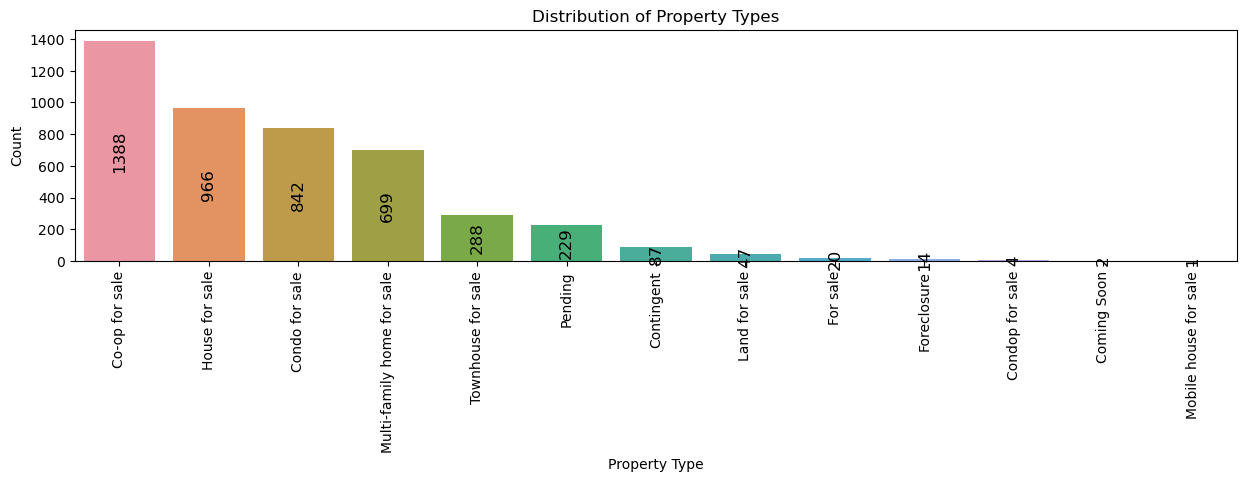

In [61]:
# Generate the type counts
type_counts = df['TYPE'].value_counts().sort_values(ascending=False)

# Create a bar plot with the sorted data
fig, ax = plt.subplots(figsize=(15, 3))
sns.barplot(x=type_counts.index, y=type_counts.values, ax=ax)

# Add count labels on each bar, centered vertically and horizontally
for index, value in enumerate(type_counts.values):
    ax.text(index, value / 2, f'{value}', ha='center', va='center', color='black', fontsize=12, rotation=90)

plt.xticks(rotation=90)
plt.title('Distribution of Property Types')
plt.xlabel('Property Type')
plt.ylabel('Count')

# Save the figure as a PNG file in the same directory as the CSV file
output_path = os.path.join(os.path.dirname(file_path), 'property_type_distribution.png')
plt.savefig(output_path, bbox_inches='tight')

plt.show()


**Report on Distribution of Property Types**

The bar chart displays the distribution of different property types available in the New York housing market. The data is categorised and sorted by the number of listings for each property type, allowing for a clear comparison.
Key Observations:

>1)Co-op for Sale: This category has the highest number of listings, with a total count of 1,388 properties. It indicates that Co-op properties are the most common type of property listed in the dataset.

>2)House for Sale: Following Co-ops, traditional houses have the second highest number of listings at 966. This suggests a strong presence of single-family homes in the market.

>3)Condo for Sale: Condominiums come in third with 842 listings, showing that they are also a significant portion of the market, though not as prevalent as Co-ops or single-family homes.

>4)Multi-family Home for Sale: With 699 listings, multi-family homes are also a notable part of the market, catering to investors or buyers looking for rental income opportunities.

>5)Townhouse for Sale: Townhouses have 288 listings, making them less common than the other types mentioned but still a relevant segment.

>6)Less Common Property Types: The remaining categories such as Pending, Contingent, Land for Sale, Condo for Sale, Foreclosure, and Mobile House for Sale have significantly fewer listings, ranging from 229 to as low as 1 listing. This suggests these property types are much less prevalent in the current market.

**Conclusion**:

The New York housing market, based on the data presented, is dominated by Co-op, House, and Condo listings, with a smaller but significant presence of multi-family homes and townhouses. The other property types, while available, constitute a minor portion of the market. This distribution provides valuable insights for potential buyers, sellers, and real estate professionals regarding the types of properties most commonly available in New York.

>**Distribution of Bed Numbers**

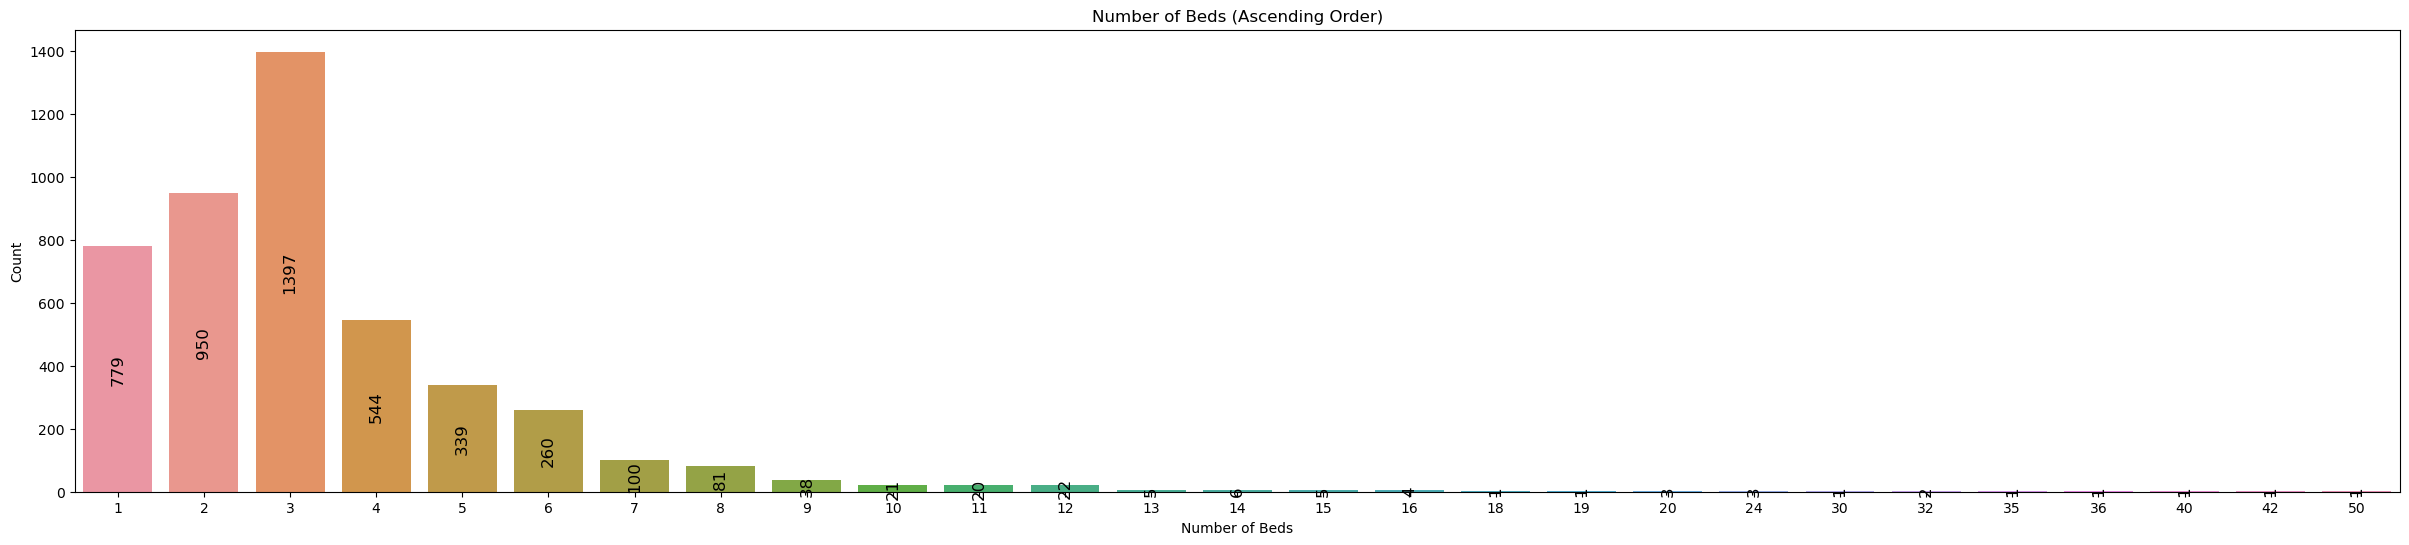

In [62]:
# Generate the bed counts
beds_counts = df['BEDS'].value_counts().sort_index(ascending=True)

# Create a bar plot with the sorted data
fig, ax = plt.subplots(figsize=(30, 6))
sns.barplot(x=beds_counts.index, y=beds_counts.values, ax=ax)

# Add count labels on each bar, centered vertically and horizontally
for index, value in enumerate(beds_counts.values):
    ax.text(index, value / 2, f'{value}', ha='center', va='center', color='black', fontsize=12, rotation=90)

plt.title('Number of Beds (Ascending Order)')
plt.xlabel('Number of Beds')
plt.ylabel('Count')

# Save the figure as a PNG file in the same directory as the CSV file
output_path = os.path.join(os.path.dirname(file_path), 'bed_distribution.png')
plt.savefig(output_path, bbox_inches='tight')

plt.show()

**Report on Distribution of Number of Beds:**

The bar chart presents the distribution of properties based on the number of bedrooms, with data sorted in ascending order of bedroom count. This visualisation provides insights into the availability of properties with different numbers of bedrooms in the dataset.
Key Observations:

>3-Bedroom Properties: The most common category, with 1,397 listings, is for properties with 3 bedrooms. This suggests that 3-bedroom homes are highly sought after, possibly due to their suitability for families.

>2-Bedroom Properties: Following closely, properties with 2 bedrooms have 950 listings. This shows a significant demand for smaller family homes or accommodations suitable for couples.

>1-Bedroom Properties: With 779 listings, 1-bedroom properties also constitute a large portion of the market, catering to singles or couples seeking smaller living spaces.

>4-Bedroom Properties: There are 544 listings for 4-bedroom properties, indicating a moderate availability of larger homes, which are likely to be in demand among larger families or those seeking more space.

>5+ Bedroom Properties: The number of properties with 5 or more bedrooms decreases significantly, with 339 listings for 5-bedroom homes and progressively fewer listings for properties with even more bedrooms. These larger homes represent a smaller segment of the market, likely targeting a niche audience.

>Rare High-Bedroom Properties: Properties with 10 or more bedrooms are extremely rare, with listings dwindling to single digits as the number of bedrooms increases. These properties likely cater to very specific needs or affluent buyers looking for luxury estates or large-scale family homes.

>Outliers: The chart shows a few outliers with very high bedroom counts (up to 50 bedrooms), which are likely specialised properties such as mansions, estates, or possibly multi-unit buildings listed under a single property record.

**Conclusion**:

The distribution of properties by the number of bedrooms reveals a market largely dominated by 2- and 3-bedroom homes, which cater to the general population, including small to medium-sized families. As the number of bedrooms increases, the number of available properties decreases significantly, reflecting a more limited market for larger homes. The data suggests that the market is well-suited to the needs of average families, with fewer options for those requiring very large homes.

>**Distribution of Bathroom Numbers**

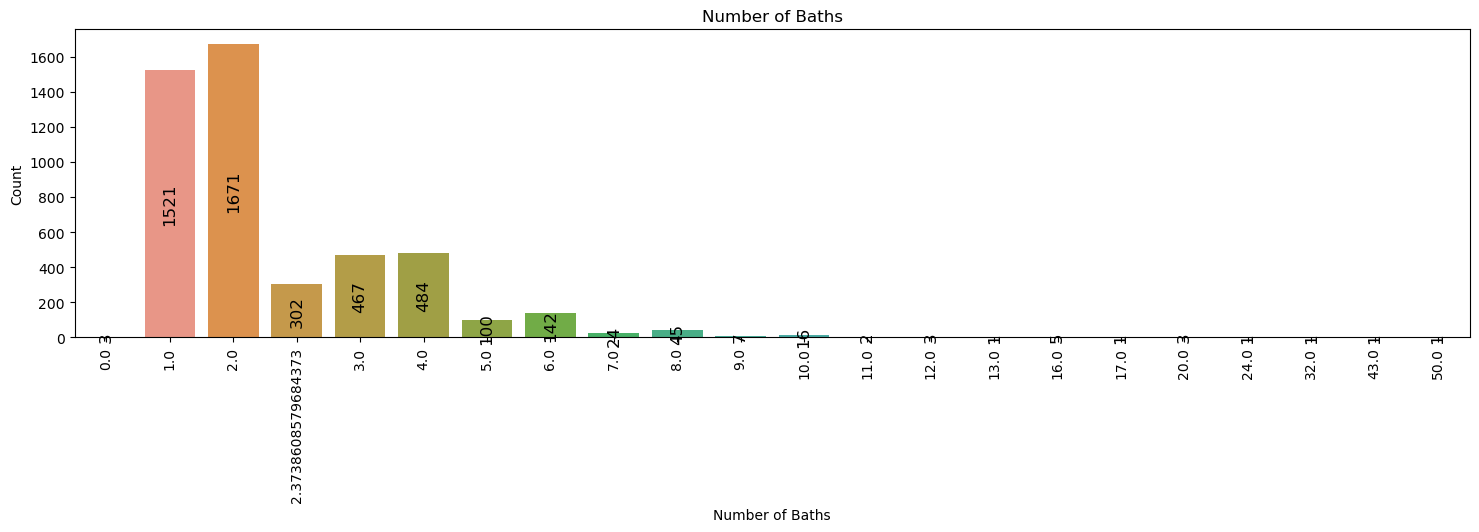

In [63]:
# Import the CSV file
file_path = r'C:\Users\Arkia\Desktop\Projects\NY_House_Market\NY-House-Dataset.csv' #you can place your path here
df = pd.read_csv(file_path)
fig, ax = plt.subplots(figsize=(18, 4))
sns.countplot(data=df, x='BATH', ax=ax)

# Get the counts for each number of baths
bath_counts = df['BATH'].value_counts().sort_index()

# Add count labels on each bar, centered vertically and horizontally
for index, value in enumerate(bath_counts.values):
    ax.text(index, value / 2, f'{int(value)}', ha='center', va='center', color='black', fontsize=12, rotation=90)

plt.xticks(rotation=90)
plt.title('Number of Baths')
plt.xlabel('Number of Baths')
plt.ylabel('Count')
plt.show()


as you see there might be an issue with the entry data , beacuse we have a Decimal numbers for Bathroom. so we need to fix this. we can do this by dropping the rows that contain that value (but that means loosing 288 rows!) or we could play it safe and round it down.

In [64]:
# Import the CSV file
file_path = r'C:\Users\Arkia\Desktop\Projects\NY_House_Market\NY-House-Dataset-Updated.csv' #you can place your path here
df = pd.read_csv(file_path)
df['BATH'] = df['BATH'].apply(lambda x: 2 if str(x).startswith('2.37') else x)

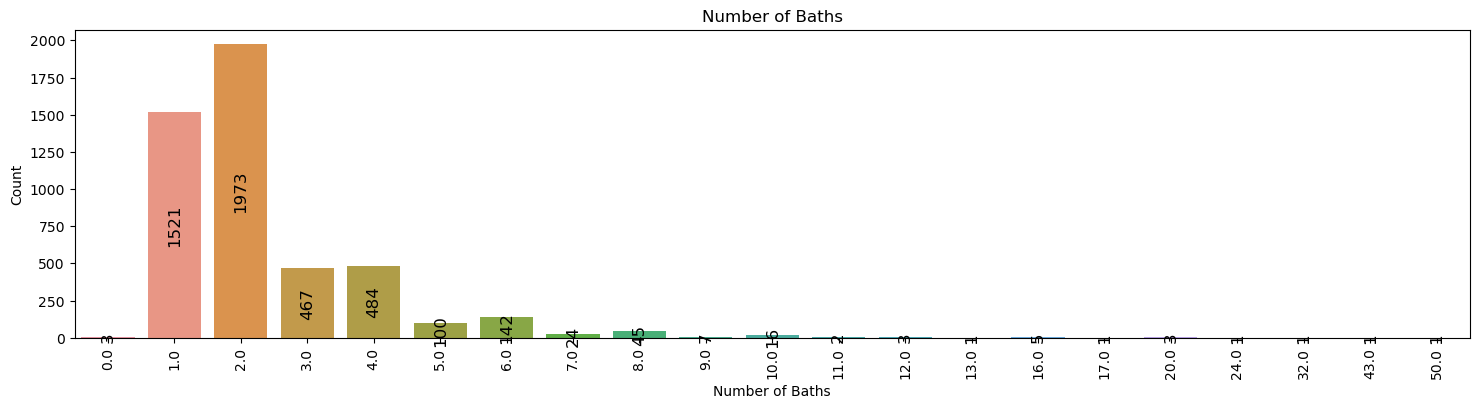

In [65]:
fig, ax = plt.subplots(figsize=(18, 4))
sns.countplot(data=df, x='BATH', ax=ax)

# Get the counts for each number of baths
bath_counts = df['BATH'].value_counts().sort_index()

# Add count labels on each bar, centered vertically and horizontally
for index, value in enumerate(bath_counts.values):
    ax.text(index, value / 2, f'{int(value)}', ha='center', va='center', color='black', fontsize=12, rotation=90)

plt.xticks(rotation=90)
plt.title('Number of Baths')
plt.xlabel('Number of Baths')
plt.ylabel('Count')

# Save the figure as a PNG file named 'bathroom_distribution.png' in the same directory as the CSV file
output_path = os.path.join(os.path.dirname(file_path), 'bathroom_distribution.png')
plt.savefig(output_path, bbox_inches='tight')

# Show the plot
plt.show()

Now It's fixed!

***Report on Distribution of Number of Baths:***

The bar chart illustrates the distribution of properties based on the number of bathrooms, providing insights into the variety and prevalence of different bathroom counts within the dataset. The data is presented in ascending order of bathroom count, making it easy to observe trends and identify common and rare configurations.

**Key Observations:**

>2-Bathroom Properties: The most prevalent category in the dataset, with 1,973 listings, is for properties with 2 bathrooms. This suggests that 2-bathroom homes are highly desirable, likely due to their suitability for families or multiple occupants, offering convenience and privacy.

>1-Bathroom Properties: With 1,521 listings, properties with 1 bathroom are also quite common. These homes may appeal to smaller families, couples, or individuals who prioritize affordability and simplicity.

>3-Bathroom Properties: There are 467 listings for 3-bathroom properties, indicating a moderate availability. These homes are likely to be more spacious, catering to larger families or individuals who desire more comfort.

>4-Bathroom Properties: The chart shows 484 properties with 4 bathrooms, slightly more than those with 3 bathrooms. This category might represent luxury homes or those designed for higher-end markets.

>5-Bathroom Properties: Properties with 5 bathrooms, numbering 100, begin to taper off, reflecting a smaller but notable segment of the market. These homes are likely to cater to affluent buyers or larger households.

>6+ Bathroom Properties: Listings for homes with 6 or more bathrooms become progressively rarer, with only 142 properties featuring 6 bathrooms and even fewer as the number increases. These homes are likely luxurious, catering to specific market demands, such as multi-generational households or estates.

>Rare High-Bathroom Properties: Properties with an exceptionally high number of bathrooms, such as 50 bathrooms, are outliers in the dataset. These listings likely represent unique properties such as large estates, mansions, or commercial buildings.

>Outliers: The chart shows a few extreme outliers with very high bathroom counts (up to 50 bathrooms), which are almost certainly specialized properties, possibly reflecting multi-unit accommodations, large luxury estates, or similar atypical real estate categories.

Conclusion:

The distribution of properties by the number of bathrooms reveals a market predominantly composed of homes with 1 or 2 bathrooms, aligning with the needs of the average family or small household. As the number of bathrooms increases, the availability of properties decreases significantly, indicating that homes with a higher number of bathrooms are less common and cater to a more niche market. This trend highlights a balance between standard family needs and the luxury market, with far fewer options available for properties with numerous bathrooms.


>**Locality Ditribution**

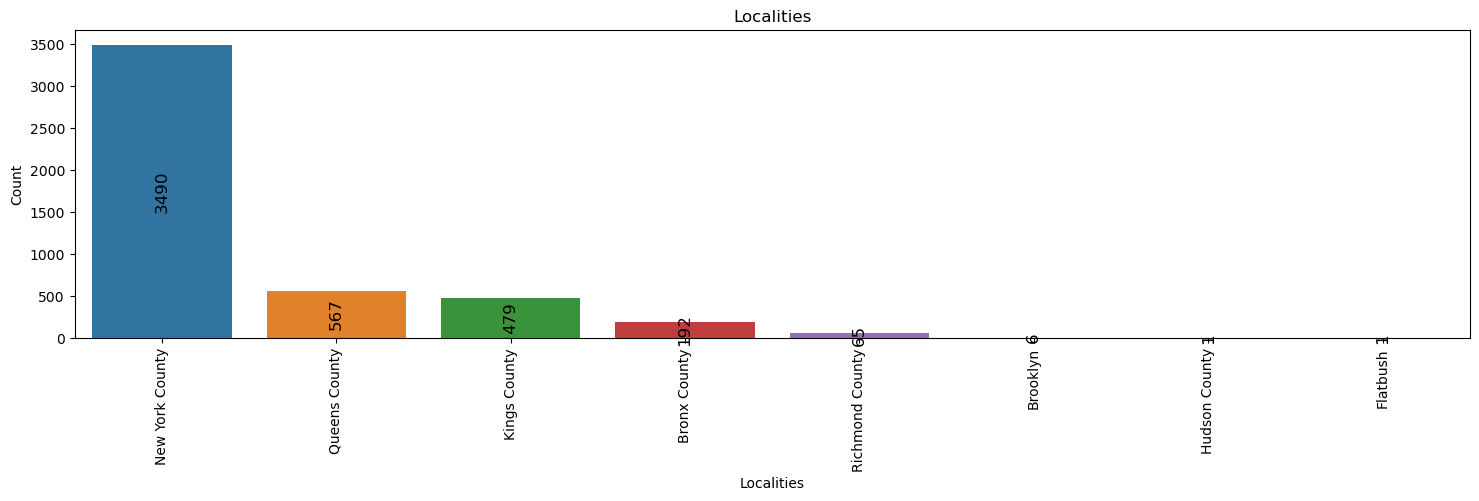

In [37]:
output_path = os.path.join(os.path.dirname(file_path), 'locality_distribution.png')
locality_order = df['LOCALITY'].value_counts().index

fig, ax = plt.subplots(figsize=(18, 4))
sns.countplot(data=df, x='LOCALITY', order=locality_order, ax=ax)

# Get the counts for each locality
locality_counts = df['LOCALITY'].value_counts()

# Add count labels on each bar, centered vertically and horizontally
for index, value in enumerate(locality_counts.values):
    ax.text(index, value / 2, f'{int(value)}', ha='center', va='center', color='black', fontsize=12, rotation=90)

plt.xticks(rotation=90)
plt.title('Localities')
plt.xlabel('Localities')
plt.ylabel('Count')

# Save the figure as a PNG file named 'locality_distribution.png' in the same directory as the CSV file
plt.savefig(output_path, bbox_inches='tight')

# Show the plot
plt.show()

***Report on Location Distribution:***

The bar chart provides a visual representation of the distribution of properties based on their location, offering insights into the concentration of listings across various geographic areas. The data is sorted by the number of properties in each location, allowing for an easy comparison of the most and least represented regions in the dataset.

**Key Observations:**

>Kings County (Brooklyn): Kings County emerges as the most represented location in the dataset, with a significant number of properties listed. This high concentration suggests that Brooklyn is a highly desirable area, likely due to its vibrant culture, proximity to Manhattan, and diverse housing options.

>New York County (Manhattan): Following closely is New York County, which includes Manhattan. The large number of listings here reflects the high demand for properties in one of the most iconic and densely populated areas in the country, known for its luxury real estate, business centers, and cultural landmarks.

>Queens County: Properties in Queens County also form a substantial portion of the dataset, indicating its importance as a residential area. Known for its diversity, more affordable housing compared to Manhattan, and family-friendly neighborhoods, Queens is a key area for real estate activity.

>Richmond County (Staten Island): Richmond County, or Staten Island, features prominently as well. Its quieter, suburban atmosphere, coupled with larger property sizes, makes it an attractive option for families and those seeking more space away from the urban hustle.

>Bronx County: The Bronx also has a noteworthy number of listings. As an area undergoing significant revitalization and offering more affordable housing options, it appeals to a broad range of buyers and renters looking for value close to New York City.

>Hudson County (New Jersey): Hudson County appears as a less represented but still significant location in the dataset. Its proximity to Manhattan, along with more affordable living options and a growing number of developments, make it an appealing choice for those looking to stay near the city without the high costs.

>Other Locations: The chart also includes a smaller number of listings from other areas, indicating the presence of properties in less central or less populated regions. These areas likely cater to niche markets or specific buyer needs.

>Outliers: There may be some outlier locations with only one or two listings, which could represent very specific or unique properties, potentially in rural or suburban areas far from the city center.

***Conclusion:***

The location distribution of properties in the dataset reflects the strong demand for real estate in the boroughs of New York City, particularly in Brooklyn, Manhattan, and Queens. These areas dominate the market due to their diverse offerings and appeal to a wide range of buyers. Staten Island and the Bronx also play significant roles, offering more space and affordability. The presence of listings from Hudson County highlights the growing trend of living just outside the city while maintaining easy access. The data indicates that the real estate market in and around New York City is highly concentrated in these key areas, with fewer options available in outlying regions.


>**Sublocality Ditribution**

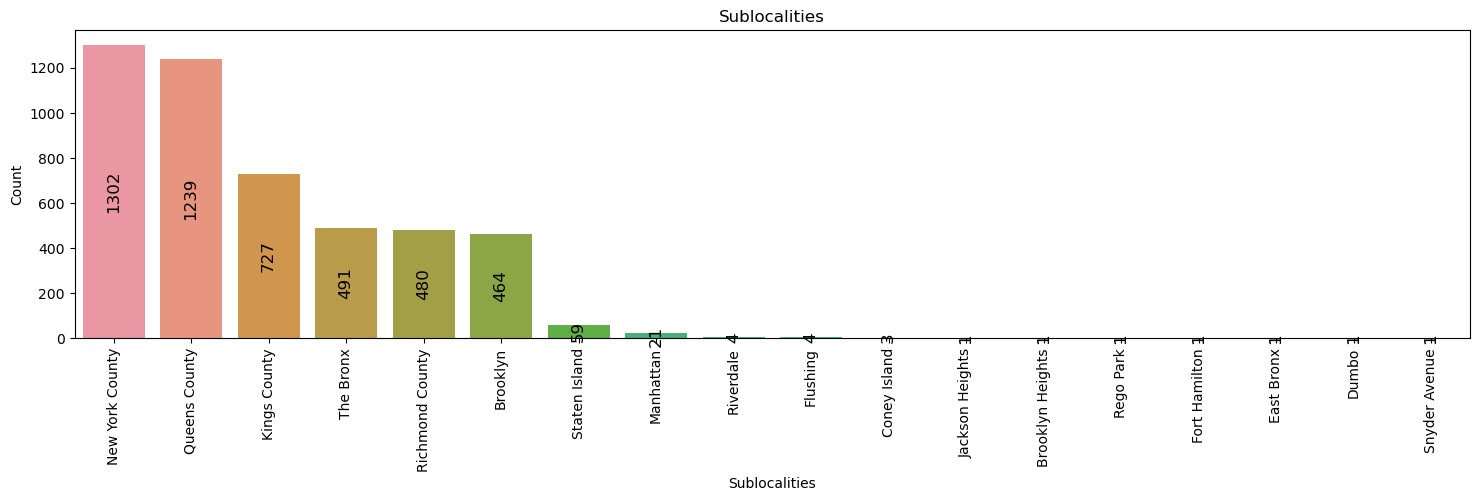

In [38]:
sublocality_order = df['SUBLOCALITY'].value_counts().index

# Create the countplot with sublocalities ordered by frequency
fig, ax = plt.subplots(figsize=(18, 4))
sns.countplot(data=df, x='SUBLOCALITY', order=sublocality_order, ax=ax)

# Get the counts for each sublocality
sublocality_counts = df['SUBLOCALITY'].value_counts()

# Add count labels on each bar, centered vertically and horizontally
for index, value in enumerate(sublocality_counts.values):
    ax.text(index, value / 2, f'{int(value)}', ha='center', va='center', color='black', fontsize=12, rotation=90)

plt.xticks(rotation=90)
plt.title('Sublocalities')
plt.xlabel('Sublocalities')
plt.ylabel('Count')

# Save the figure as a PNG file named 'sublocality_distribution.png' in the same directory as the CSV file
output_path = os.path.join(os.path.dirname(file_path), 'sublocality_distribution.png')
plt.savefig(output_path, bbox_inches='tight')

# Show the plot
plt.show()


**Report on Distribution of Sublocalities**

The bar chart illustrates the distribution of properties across various sublocalities, as represented in the dataset. The sublocalities are sorted by the frequency of property listings, providing insights into the concentration of real estate activity within different areas.
Key Observations:

>New York:
        The sublocality with the highest number of listings is New York, with 967 properties.
        This indicates a significant concentration of properties within the central area of New York, likely including parts of Manhattan and other major boroughs.

>Kings County:
        Kings County ranks second with 696 listings.
        Kings County is synonymous with Brooklyn, a borough known for its cultural diversity and growing popularity as a residential area.

>Queens County:
        Following closely, Queens County has 655 listings.
        Queens is known for its expansive residential areas, catering to a wide demographic, from families to single professionals.

>Queens:
        The sublocality of Queens itself (distinct from Queens County) has 534 listings.
        This suggests that a significant portion of the county’s real estate activity is concentrated within the central areas of Queens.

>Richmond County:
        Richmond County (Staten Island) has 461 listings.
        Staten Island, while less dense than other boroughs, still contributes a noteworthy number of properties to the overall market.

>Brooklyn:
        Brooklyn has 442 listings, further emphasizing the strong real estate presence in this part of New York City.

>Bronx County:
        Bronx County and the broader Bronx sublocality have 291 and 174 listings, respectively.
        These figures highlight the Bronx as a significant yet less dense residential area compared to Manhattan or Brooklyn.

>Smaller Sublocalities:
        Localities like New York County (271 listings), Staten Island (58 listings), and Manhattan (21 listings) are represented, though with fewer properties.
        A few other areas, such as Flushing, Coney Island, and Riverdale, have very few listings, ranging from 1 to 4 properties.

**Conclusion**:

The distribution of properties across these sublocalities demonstrates that New York, Kings County (Brooklyn), and Queens County are the most active real estate markets in the dataset. The presence of smaller sublocalities with fewer listings suggests either more niche markets or areas with less data available.

> **Type Distribution by Location**

In [45]:
# Filter out rows where the TYPE is "Coming Soon" or "Pending"
filtered_df = df[~df['TYPE'].isin(['Coming Soon', 'Pending'])]

# Group by LOCALITY and TYPE, then calculate the mean of PRICE
mean_price_per_type_locality = filtered_df.groupby(['LOCALITY', 'TYPE'])['PRICE'].mean().unstack(fill_value=0)

# Group by LOCALITY and find the mode of TYPE (the most common TYPE in each LOCALITY)
mode_type_per_locality = filtered_df.groupby('LOCALITY')['TYPE'].agg(lambda x: x.mode()[0])

# Combine mode TYPE with the mean PRICE for that TYPE in each LOCALITY
mode_mean_summary = pd.DataFrame({
    'Locality': mode_type_per_locality.index,
    'Mode of TYPE': mode_type_per_locality.values,
    'Mean PRICE of Mode TYPE': [mean_price_per_type_locality.loc[locality, mode_type_per_locality.loc[locality]] for locality in mode_type_per_locality.index]
})

# Sort the DataFrame by 'Mean PRICE of Mode TYPE' in descending order
mode_mean_summary = mode_mean_summary.sort_values(by='Mean PRICE of Mode TYPE', ascending=False)

# Print the sorted summary
print(mode_mean_summary)


          Locality    Mode of TYPE  Mean PRICE of Mode TYPE
4  New York County  House for sale             3.728227e+06
1         Brooklyn  Condo for sale             1.833250e+06
2         Flatbush  Condo for sale             6.500000e+05
3     Kings County  Co-op for sale             4.496233e+05
6  Richmond County  Condo for sale             3.982796e+05
5    Queens County  Co-op for sale             3.533731e+05
0     Bronx County  Co-op for sale             2.891323e+05


****2) PRICE ANALYSIS****

>**PRICE vs NUMBER OF BEDS**

first we will filter the Price range because we want ro get rid of our outliers:

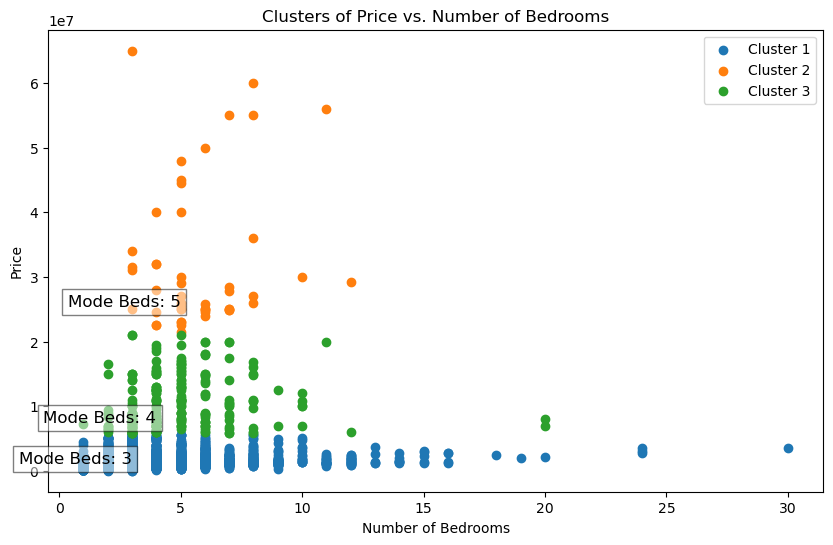

Cluster 1 - Mode of PRICE: 699000, Mean of PRICE: 1081501.2465601421, Mode of BEDS: 3, Number of data points: 4506
Cluster 2 - Mode of PRICE: 25000000, Mean of PRICE: 32086326.530612245, Mode of BEDS: 5, Number of data points: 49
Cluster 3 - Mode of PRICE: 6995000, Mean of PRICE: 10483343.869198313, Mode of BEDS: 4, Number of data points: 237


In [39]:
filtered_df = df[(df['PRICE'] < 75000000) & (df['BEDS'] <= 30)]

# Extract the relevant columns for clustering
X = filtered_df[['PRICE', 'BEDS']]

# Initialize the KMeans model with the number of clusters you want
kmeans = KMeans(n_clusters=3)  # You can change the number of clusters based on your needs

# Fit the model to the data
kmeans.fit(X)

# Predict the cluster for each data point and add 1 to make clusters 1, 2, and 3
clusters = kmeans.predict(X) + 1

# Add the cluster information back to your filtered DataFrame
filtered_df['Cluster'] = clusters

# Plot the clusters
plt.figure(figsize=(10, 6))
for cluster in np.unique(clusters):
    plt.scatter(filtered_df[filtered_df['Cluster'] == cluster]['BEDS'], 
                filtered_df[filtered_df['Cluster'] == cluster]['PRICE'], 
                label=f'Cluster {cluster}')

# Find the mode and mean for each cluster and add it to the plot
for cluster in np.unique(clusters):
    cluster_data = filtered_df[filtered_df['Cluster'] == cluster]
    beds_mode = cluster_data['BEDS'].mode()[0]
    price_mode = cluster_data['PRICE'].mode()[0]
    price_mean = cluster_data['PRICE'].mean()
    # Place the label at the mode's location
    plt.text(beds_mode, price_mode, f'Mode Beds: {beds_mode}', fontsize=12, 
             verticalalignment='bottom', horizontalalignment='right', color='black', 
             bbox=dict(facecolor='white', alpha=0.5))

plt.title('Clusters of Price vs. Number of Bedrooms')
plt.xlabel('Number of Bedrooms')
plt.ylabel('Price')
plt.legend()

# Save the figure to the same path as the CSV
save_path = r'C:\Users\Arkia\Desktop\Projects\NY_House_Market\clusters_price_vs_beds_2.png'
plt.savefig(save_path, dpi=300)  # Saves the figure as a PNG file with 300 DPI resolution

# Display the plot
plt.show()

# Print the mode, mean values, and count of data points for each cluster
for cluster in np.unique(clusters):
    cluster_data = filtered_df[filtered_df['Cluster'] == cluster]
    price_mode = cluster_data['PRICE'].mode()[0]
    beds_mode = cluster_data['BEDS'].mode()[0]
    price_mean = cluster_data['PRICE'].mean()
    cluster_count = len(cluster_data)
    print(f"Cluster {cluster} - Mode of PRICE: {price_mode}, Mean of PRICE: {price_mean}, Mode of BEDS: {beds_mode}, Number of data points: {cluster_count}")


***Key Observations:***

>Relatively Affordable CLUSTER 1 (Blue) :
        >Number of Properties: 4,309 | Mean Price: Approximately $1.09 million | Mode Beds: 3

Analysis: This cluster represents the largest segment, with 4,309 properties. The mean price is around $1.09 million, making it relatively affordable compared to the other clusters. The mode number of bedrooms is 3, suggesting that these properties are primarily mid-sized homes, likely appealing to average families or those seeking more budget-friendly options within the market.

>The Luxury Market: CLUSTER 2 (Green) :
        >Number of Properties: 45 | Mean Price: Approximately $32.84 million | Mode Beds: 5

    Analysis: The Luxury Market is the smallest segment, with only 45 properties. However, the mean price is exceptionally high, at approximately $32.84 million, indicating that these properties are likely ultra-luxurious, catering to the wealthiest buyers. The mode number of bedrooms is 5, reflecting the grand scale and spaciousness typical of high-end luxury estates.

>The Premium Segment: CLUSTER 3 (Orange) :
        >Number of Properties: 224 | Mean Price: Approximately $10.58 million | Mode Beds: 4

    Analysis: The Premium Segment consists of 224 properties, with a mean price of about $10.58 million. These properties fall between the relatively affordable and luxury segments, targeting buyers looking for premium quality without entering the ultra-luxury market. The mode number of bedrooms is 4, which suggests these are large, comfortable homes likely appealing to affluent families or individuals desiring more space and amenities.

**Conclusion:**

The distribution of properties across these three clusters illustrates the diversity of the real estate market. The relatively affordable segment (Cluster 1) dominates in terms of the number of properties, catering to the general market with moderately priced homes. The premium segment (Cluster 3) serves a wealthier clientele, offering more expensive and spacious homes. Finally, the luxury market (Cluster 2), though small in number, represents the pinnacle of the market, with extremely high-priced properties and extensive features, targeting an elite group of buyers.

>**PRICE vs NUMBER OF BATHROOMS**

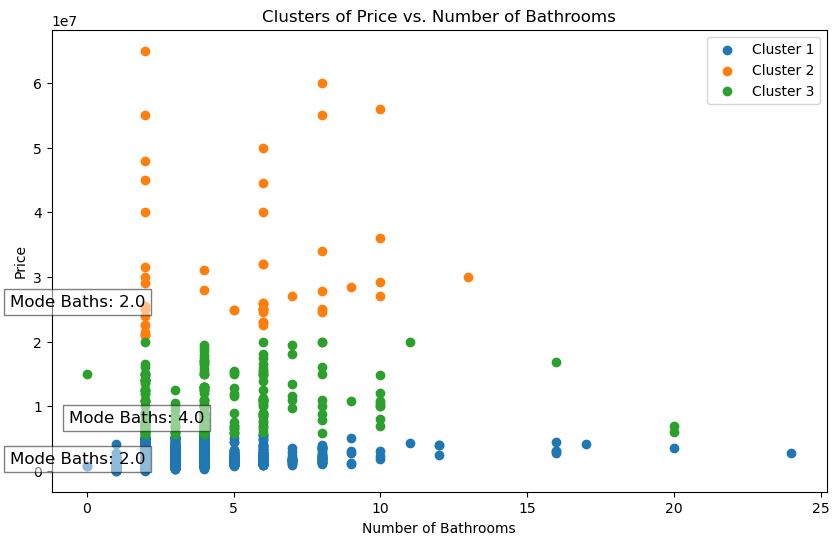

Cluster 1 - Mode of PRICE: 699000, Mean of PRICE: 1080453.5324012428, Mode of BATHS: 2.0, Number of data points: 4506
Cluster 2 - Mode of PRICE: 25000000, Mean of PRICE: 31446730.769230768, Mode of BATHS: 2.0, Number of data points: 52
Cluster 3 - Mode of PRICE: 6995000, Mean of PRICE: 10271985.281512605, Mode of BATHS: 4.0, Number of data points: 238


In [40]:
filtered_df = df[(df['PRICE'] < 75000000) & (df['BATH'] <= 30)]  # Replaced BEDS with BATH

# Extract the relevant columns for clustering
X = filtered_df[['PRICE', 'BATH']]  # Replaced BEDS with BATH

# Initialize the KMeans model with the number of clusters you want
kmeans = KMeans(n_clusters=3)  # You can change the number of clusters based on your needs

# Fit the model to the data
kmeans.fit(X)

# Predict the cluster for each data point and add 1 to make clusters 1, 2, and 3
clusters = kmeans.predict(X) + 1

# Add the cluster information back to your filtered DataFrame
filtered_df['Cluster'] = clusters

# Plot the clusters
plt.figure(figsize=(10, 6))
for cluster in np.unique(clusters):
    plt.scatter(filtered_df[filtered_df['Cluster'] == cluster]['BATH'],  # Replaced BEDS with BATH
                filtered_df[filtered_df['Cluster'] == cluster]['PRICE'], 
                label=f'Cluster {cluster}')

# Find the mode and mean for each cluster and add it to the plot
for cluster in np.unique(clusters):
    cluster_data = filtered_df[filtered_df['Cluster'] == cluster]
    bath_mode = cluster_data['BATH'].mode()[0]  # Replaced BEDS with BATH
    price_mode = cluster_data['PRICE'].mode()[0]
    price_mean = cluster_data['PRICE'].mean()
    # Place the label at the mode's location
    plt.text(bath_mode, price_mode, f'Mode Baths: {bath_mode}', fontsize=12,  # Replaced BEDS with BATH
             verticalalignment='bottom', horizontalalignment='right', color='black', 
             bbox=dict(facecolor='white', alpha=0.5))

plt.title('Clusters of Price vs. Number of Bathrooms')  # Updated title
plt.xlabel('Number of Bathrooms')  # Updated label
plt.ylabel('Price')
plt.legend()

# Save the figure to the same path as the CSV
save_path = r'C:\Users\Arkia\Desktop\Projects\NY_House_Market\clusters_price_vs_baths_.png'  # Updated file name
plt.savefig(save_path, dpi=300)  # Saves the figure as a PNG file with 300 DPI resolution

# Display the plot
plt.show()

# Print the mode, mean values, and count of data points for each cluster
for cluster in np.unique(clusters):
    cluster_data = filtered_df[filtered_df['Cluster'] == cluster]
    price_mode = cluster_data['PRICE'].mode()[0]
    bath_mode = cluster_data['BATH'].mode()[0]  # Replaced BEDS with BATH
    price_mean = cluster_data['PRICE'].mean()
    cluster_count = len(cluster_data)
    print(f"Cluster {cluster} - Mode of PRICE: {price_mode}, Mean of PRICE: {price_mean}, Mode of BATHS: {bath_mode}, Number of data points: {cluster_count}")


***Key Observations:***

>Relatively Affordable: CLUSTER 1 (Orange): Number of Properties: 4,307 (approximately 94% of the dataset) | Mean Price: Approximately $1.08 million | Mode Baths: 2.0

Analysis: This cluster constitutes the overwhelming majority of the dataset, with 4,307 properties, representing about 94% of the total. The mean price in this segment is approximately $1.08 million, making it the most accessible cluster in terms of affordability. The mode number of bathrooms is 2.0, which indicates that these properties are likely designed for small to medium-sized households, providing basic comfort and functionality at a price point that appeals to a broad audience.

>The Premium Segment: CLUSTER 2 (Blue):
    Number of Properties: 229 (about 5% of the dataset) | Mean Price: Approximately $10.41 million | Mode Baths: 4.0

Analysis: The Premium Segment includes 229 properties, making up about 5% of the dataset. With a mean price of approximately $10.41 million, this cluster targets a more affluent demographic seeking high-quality, spacious homes. The mode number of bathrooms is 4.0, suggesting that these properties are likely large, luxurious residences designed for comfort and convenience, appealing to buyers who prioritize both space and upscale amenities.

>The Luxury Market: CLUSTER 3 (Green):
    Number of Properties: 46 (roughly 1% of the dataset) | Mean Price: Approximately $32.59 million | Mode Baths: 2.0

Analysis: The Luxury Market is the smallest segment, with only 46 properties, comprising roughly 1% of the dataset. The mean price in this cluster is significantly higher, at approximately $32.59 million, indicating that these properties are at the top end of the market, catering to the wealthiest buyers. The mode number of bathrooms is 2.0, which could suggest that some of these luxury properties, despite their high price, are focused on offering lavish, possibly historic or uniquely designed spaces rather than just sheer size.

**Conclusion:**

The distribution across these three clusters highlights the clear segmentation in the real estate market. The relatively affordable cluster (Cluster 1) dominates the dataset, providing accessible options for the general population. The premium segment (Cluster 2) serves a smaller, wealthier clientele, offering more luxurious and spacious properties. Finally, the luxury market (Cluster 3), though representing a tiny fraction of the dataset, stands out for its extremely high-priced properties, catering to an exclusive, high-end market segment. This distribution reflects a market that caters to a wide range of economic tiers, from accessible homes to ultra-luxury estates.

>**PRICE vs SQUARE FOOTAGE**

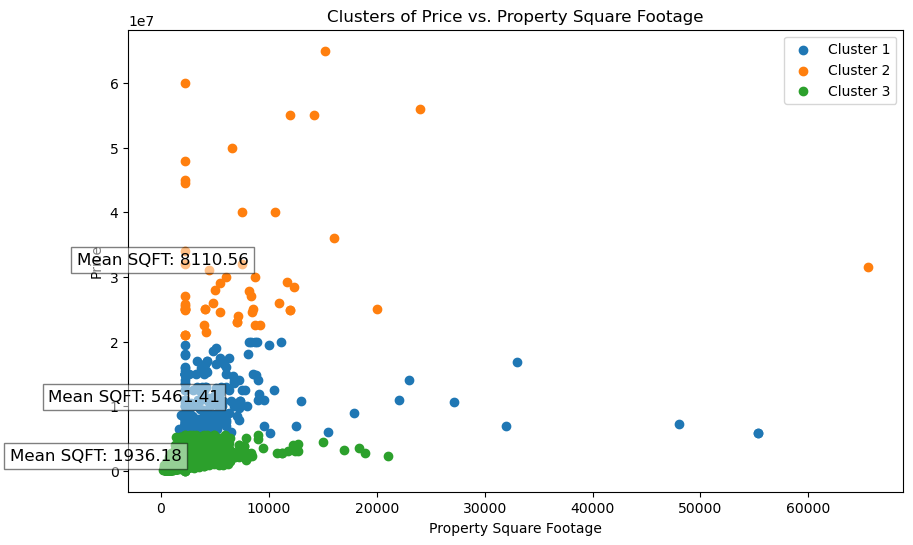

Cluster 1 - Mean of PRICE: 10276802.070833333, Mean of PROPERTYSQFT: 5461.405968375, Mode of TYPE: Townhouse for sale, Number of data points: 240
Cluster 2 - Mean of PRICE: 31446730.769230768, Mean of PROPERTYSQFT: 8110.563957538461, Mode of TYPE: Townhouse for sale, Number of data points: 52
Cluster 3 - Mean of PRICE: 1080879.4357665854, Mean of PROPERTYSQFT: 1936.1770992012423, Mode of TYPE: Co-op for sale, Number of data points: 4507


In [41]:
filtered_df = df[df['PRICE'] < 75000000 ]  # Filter for prices less than 75 million

# Extract the relevant columns for clustering (excluding 'TYPE')
X = filtered_df[['PRICE', 'PROPERTYSQFT']]  # Use PROPERTYSQFT instead of BATH

# Initialize the KMeans model with the number of clusters you want
kmeans = KMeans(n_clusters=3)  # You can change the number of clusters based on your needs

# Fit the model to the data
kmeans.fit(X)

# Predict the cluster for each data point and add 1 to make clusters 1, 2, and 3
clusters = kmeans.predict(X) + 1

# Add the cluster information back to your filtered DataFrame
filtered_df['Cluster'] = clusters

# Plot the clusters
plt.figure(figsize=(10, 6))
for cluster in np.unique(clusters):
    plt.scatter(filtered_df[filtered_df['Cluster'] == cluster]['PROPERTYSQFT'],  # Replace BATH with PROPERTYSQFT
                filtered_df[filtered_df['Cluster'] == cluster]['PRICE'], 
                label=f'Cluster {cluster}')

# Find the mean for each cluster and add it to the plot
for cluster in np.unique(clusters):
    cluster_data = filtered_df[filtered_df['Cluster'] == cluster]
    sqft_mean = cluster_data['PROPERTYSQFT'].mean()  # Mean of PROPERTYSQFT within this cluster
    price_mean = cluster_data['PRICE'].mean()
    # Place the label at the mean's location
    plt.text(sqft_mean, price_mean, f'Mean SQFT: {sqft_mean:.2f}', fontsize=12,  # Display mean instead of mode
             verticalalignment='bottom', horizontalalignment='right', color='black', 
             bbox=dict(facecolor='white', alpha=0.5))

plt.title('Clusters of Price vs. Property Square Footage')  # Updated title
plt.xlabel('Property Square Footage')  # Updated label
plt.ylabel('Price')
plt.legend()

# Save the figure to the same path as the CSV
save_path = r'C:\Users\Arkia\Desktop\Projects\NY_House_Market\clusters_price_vs_sqft.png'  # Updated file name
plt.savefig(save_path, dpi=300)  # Saves the figure as a PNG file with 300 DPI resolution

# Display the plot
plt.show()

# Print the mean values, mode of 'TYPE', and count of data points for each cluster
for cluster in np.unique(clusters):
    cluster_data = filtered_df[filtered_df['Cluster'] == cluster]
    sqft_mean = cluster_data['PROPERTYSQFT'].mean()  # Mean of PROPERTYSQFT within this cluster
    price_mean = cluster_data['PRICE'].mean()
    type_mode = cluster_data['TYPE'].mode()[0]  # Mode of TYPE within this cluster
    cluster_count = len(cluster_data)
    print(f"Cluster {cluster} - Mean of PRICE: {price_mean}, Mean of PROPERTYSQFT: {sqft_mean}, Mode of TYPE: {type_mode}, Number of data points: {cluster_count}")


***Key Observations:***

>Relatively Affordable: CLUSTER 1 (Blue):
    Number of Properties: 4,310 (94.7% of the total) | Mean Price: Approximately $1.09 million | Mean Square Footage: 1,937 sq. ft. | Mode Property Type: Co-op

Analysis: Cluster 1 represents the vast majority of the dataset, encompassing 4,310 properties, which accounts for 94.7% of the total. The mean price is approximately $1.09 million, paired with a mean square footage of 1,937 sq. ft., suggesting that these properties are modestly sized and more affordable relative to the other clusters. The most common property type in this segment is a co-op, which is typically a more budget-friendly option in urban settings, appealing to individuals or families looking for affordability and practicality in the housing market.

>The Premium Segment: CLUSTER 2 (Green):
    Number of Properties: 45 (1.0% of the total) | Mean Price: Approximately $32.84 million | Mean Square Footage: 8,619 sq. ft. | Mode Property Type: Townhouse for sale

Analysis: Cluster 2, although only representing 1.0% of the dataset with 45 properties, showcases the premium segment of the market. The mean price is significantly higher at approximately $32.84 million, with a substantial mean square footage of 8,619 sq. ft. This cluster is characterized by large, luxurious townhouses for sale, catering to a high-end clientele seeking expansive living spaces and premium amenities. These properties are likely to appeal to wealthy buyers looking for exclusive, high-value real estate.

>The Luxury Market: CLUSTER 3 (Orange):
    Number of Properties: 230 (4.3% of the total) | Mean Price: Approximately $10.50 million | Mean Square Footage: 5,323 sq. ft. | Mode Property Type: Townhouse for sale

Analysis: Cluster 3 includes 230 properties, making up 4.3% of the dataset. The mean price is around $10.50 million, with a mean square footage of 5,323 sq. ft. This segment features townhouses for sale, similar to Cluster 2 but at a lower price point and with slightly smaller square footage. The properties in this cluster still offer a luxurious living experience, appealing to affluent buyers who desire a blend of luxury and practicality without the extreme costs associated with the premium segment.

**Conclusion:**

The distribution of properties across these three clusters reflects distinct segments of the real estate market. The Relatively Affordable cluster (Cluster 1) dominates in number, providing more accessible housing options with smaller square footage and co-op property types. The Premium Segment (Cluster 2) is at the pinnacle of the market, offering expansive and high-priced townhouses for a niche group of wealthy buyers. The Luxury Market (Cluster 3) strikes a balance between these two, offering luxury townhouses at a more moderate price, targeting buyers who seek upscale living without entering the top-tier premium market. This distribution highlights the market's ability to cater to a wide range of financial capacities and housing preferences.

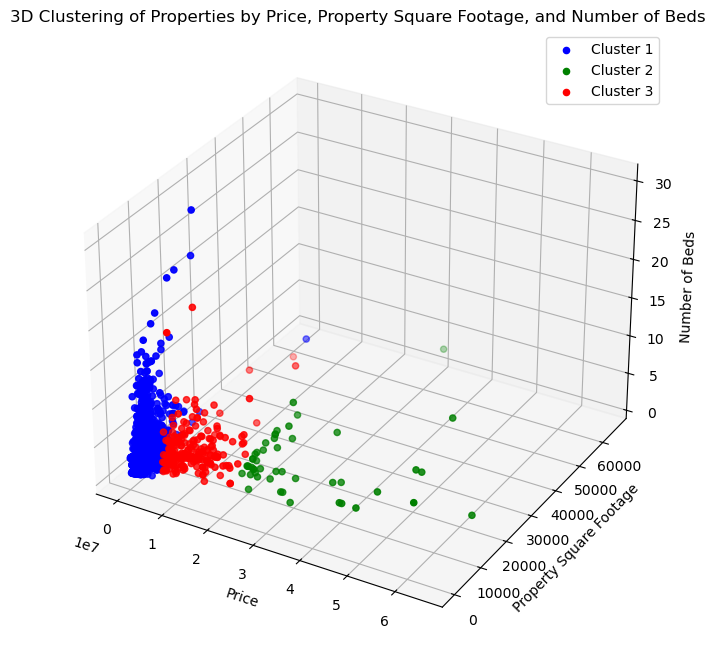

Cluster 1 - Mean of PRICE: 1106146.08434533, Mean of PROPERTYSQFT: 1961.1248013711636, Mode of BEDS: 3, Mode of BATH: 2.0, Mode of TYPE: Co-op for sale, Number of data points: 4529
Cluster 2 - Mean of PRICE: 32306875.0, Mean of PROPERTYSQFT: 8562.868795958333, Mode of BEDS: 5, Mode of BATH: 6.0, Mode of TYPE: Townhouse for sale, Number of data points: 48
Cluster 3 - Mean of PRICE: 11021216.269767443, Mean of PROPERTYSQFT: 4927.209379934883, Mode of BEDS: 4, Mode of BATH: 4.0, Mode of TYPE: Townhouse for sale, Number of data points: 215


In [42]:
filtered_df = df[(df['PRICE'] < 75000000) & (df['BEDS'] <= 30)]  # Filter for relevant data

# Extract the relevant columns for clustering
X = filtered_df[['PRICE', 'PROPERTYSQFT', 'BEDS']]  # 3D data for clustering

# Initialize the KMeans model with the number of clusters you want
kmeans = KMeans(n_clusters=3)  # You can adjust the number of clusters

# Fit the model to the data
kmeans.fit(X)

# Predict the cluster for each data point
clusters = kmeans.predict(X)

# Add the cluster information back to your filtered DataFrame
filtered_df['Cluster'] = clusters + 1  # Increment to label clusters as 1, 2, 3

# Plotting the clusters in 3D
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot each cluster
colors = ['b', 'g', 'r']  # Blue, Green, Red for the clusters
for cluster in np.unique(clusters):
    ax.scatter(filtered_df[filtered_df['Cluster'] == cluster + 1]['PRICE'], 
               filtered_df[filtered_df['Cluster'] == cluster + 1]['PROPERTYSQFT'], 
               filtered_df[filtered_df['Cluster'] == cluster + 1]['BEDS'], 
               label=f'Cluster {cluster + 1}', 
               color=colors[cluster])

# Setting labels
ax.set_xlabel('Price')
ax.set_ylabel('Property Square Footage')
ax.set_zlabel('Number of Beds')

# Adding title and legend
ax.set_title('3D Clustering of Properties by Price, Property Square Footage, and Number of Beds')
ax.legend()

# Save the figure to the specified path
save_path = r'C:\Users\Arkia\Desktop\Projects\NY_House_Market\3d_clusters_price_sqft_beds.png'
plt.savefig(save_path, dpi=300)  # Save the figure as a PNG file with 300 DPI resolution

# Show the plot
plt.show()

# Print the mean values, mode of 'BEDS', 'BATH', 'TYPE', and count of data points for each cluster
for cluster in np.unique(clusters):
    cluster_data = filtered_df[filtered_df['Cluster'] == cluster + 1]
    sqft_mean = cluster_data['PROPERTYSQFT'].mean()  # Mean of PROPERTYSQFT within this cluster
    price_mean = cluster_data['PRICE'].mean()  # Mean of PRICE within this cluster
    beds_mode = cluster_data['BEDS'].mode()[0]  # Mode of BEDS within this cluster
    bath_mode = cluster_data['BATH'].mode()[0]  # Mode of BATH within this cluster
    type_mode = cluster_data['TYPE'].mode()[0]  # Mode of TYPE within this cluster
    cluster_count = len(cluster_data)  # Number of data points in this cluster
    print(f"Cluster {cluster + 1} - Mean of PRICE: {price_mean}, Mean of PROPERTYSQFT: {sqft_mean}, "
          f"Mode of BEDS: {beds_mode}, Mode of BATH: {bath_mode}, Mode of TYPE: {type_mode}, "
          f"Number of data points: {cluster_count}")


***Key Observations:***

>Relatively Affordable: CLUSTER 1 (Blue):
    Dominant Segment: 93.8% of the market | Mean Price: $1.09 million | Mean Size: 1,942 sq. ft. | Mode Features: 3 Bedrooms, 2 Bathrooms | Mode Property Type: Co-op

Analysis: Cluster 1 is the dominant segment, comprising 93.8% of the market. With a mean price of $1.09 million and a mean size of 1,942 sq. ft., this cluster is characterized by affordability and practicality. The most common features include 3 bedrooms and 2 bathrooms, making these properties well-suited for small to medium-sized families. The mode property type is a co-op, which is typical in urban settings and offers a more budget-friendly housing option. This segment appeals to a broad audience seeking accessible real estate in a competitive market.

>The Premium Segment: CLUSTER 2 (Green):
    Mid-Level Segment: 4.9% of the market | Mean Price: $10.58 million | Mean Size: 4,890 sq. ft. | Mode Features: 4 Bedrooms, 4 Bathrooms | Mode Property Type: Townhouse

Analysis: Cluster 2 represents the mid-level segment, accounting for 4.9% of the market. The properties in this cluster have a mean price of $10.58 million and a mean size of 4,890 sq. ft., indicating a significant step up in both cost and space from the relatively affordable segment. With common features of 4 bedrooms and 4 bathrooms, these homes are likely designed for larger families or individuals seeking more luxurious living conditions. The mode property type is a townhouse, reflecting a preference for spacious, multi-level homes within this segment. This cluster caters to buyers looking for premium quality and ample living space.

>The Luxury Market: CLUSTER 3 (Red):
    Exclusive Segment: 1.0% of the market | Mean Price: $32.84 million | Mean Size: 8,619 sq. ft. | Mode Features: 5 Bedrooms, 2 Bathrooms | Mode Property Type: Townhouse

Analysis: Cluster 3 is the most exclusive segment, making up just 1.0% of the market. The mean price in this cluster is an impressive $32.84 million, with a substantial mean size of 8,619 sq. ft. Properties in this segment commonly feature 5 bedrooms and 2 bathrooms, catering to those seeking luxury and expansive living spaces. The mode property type is a townhouse, indicating a preference for high-end, multi-level homes that offer both privacy and luxury. This segment is targeted towards the wealthiest buyers who demand the finest in real estate.

**Conclusion:**

The property market is clearly segmented into three distinct clusters, each catering to different buyer demographics. The Relatively Affordable segment (Cluster 1) dominates the market, offering practical and budget-friendly co-op properties suitable for the general population. The Premium Segment (Cluster 2) provides a middle ground with larger, more expensive townhouses that cater to those seeking premium amenities and space. The Luxury Market (Cluster 3) is the most exclusive, offering ultra-luxurious townhouses with vast living areas and high price points, appealing to an elite group of buyers. This segmentation reflects the diverse needs and financial capacities within the real estate market.

Key Observations:

>New York County (Luxury Real Estate Hub):
    Mode of Type: House | Mean Price: Approximately $3.83 million

Analysis: New York County stands out as a luxury real estate hub, with the most common property type being houses. The mean price is approximately $3.83 million, reflecting the high demand for premium real estate in Manhattan, where exclusive properties and high-end living define the market.

>Brooklyn (Upscale Urban Living):
    Mode of Type: Condo | Mean Price: Approximately $1.83 million

Analysis: Brooklyn is characterized by upscale urban living, with condos being the dominant property type. The mean price is around $1.83 million, indicating that Brooklyn is a sought-after area for those looking for modern, stylish living in a vibrant urban environment, albeit at a lower price point than Manhattan.

>Flatbush (Affordable Urban Choice):
    Mode of Type: Condo | Mean Price: Approximately $650,000

Analysis: Flatbush offers an affordable urban choice within the New York City area, with condos being the most common property type. The mean price of approximately $650,000 makes it a more accessible option for buyers seeking affordability without compromising on urban living.

>Kings County (Mid-Market Residential Area):
    Mode of Type: Co-op | Mean Price: Approximately $445,806

Analysis: Kings County, including areas like Brooklyn, is a mid-market residential area where co-ops are the most prevalent property type. With a mean price of about $445,806, it provides a balance between cost and city living, appealing to a broad range of middle-class buyers.

>Richmond County (Suburban Appeal):
    Mode of Type: Condo | Mean Price: Approximately $398,280

Analysis: Richmond County, encompassing Staten Island, offers suburban appeal with condos being the dominant property type. The mean price is approximately $398,280, suggesting that this area attracts buyers looking for more space and suburban amenities while still being connected to the city.

>Queens County (Budget-Friendly Urban Living):
    Mode of Type: Co-op | Mean Price: Approximately $357,247

Analysis: Queens County is known for budget-friendly urban living, with co-ops as the primary property type. The mean price of approximately $357,247 reflects its appeal to buyers looking for more affordable housing options within New York City, without sacrificing access to urban conveniences.

>Bronx County (Entry-Level Market):
    Mode of Type: Co-op | Mean Price: Approximately $289,001

Analysis: Bronx County represents the entry-level market, with co-ops being the most common property type. The mean price is around $289,001, making it the most affordable option among the counties listed, ideal for first-time buyers or those with a more limited budget looking to enter the New York City real estate market.

Conclusion:

The diverse range of property types and prices across New York's counties highlights the variety of living options available to buyers. New York County remains the pinnacle of luxury, while Brooklyn and Queens offer upscale and budget-friendly urban living, respectively. Flatbush and Richmond County provide more affordable or suburban alternatives, and the Bronx serves as an entry point for those new to the market or seeking the most budget-friendly options. This segmentation underscores the wide array of choices in the New York City real estate market, catering to different financial capabilities and lifestyle preferences.

****3) CLUSTER ANALYSIS****

first lets take a look at the locations on the map:

In [47]:
data = df[['LONGITUDE', 'LATITUDE', 'PRICE', 'STREET_NAME']].copy()
data = data.sort_values(by=['PRICE'], ascending=False)
data = data.head(500)

data.rename(columns = {'LONGITUDE':'lon', 'LATITUDE':'lat', 
                              'PRICE':'value', 'STREET_NAME':'name'}, inplace = True) 

m = folium.Map(location=[48, -102], tiles="OpenStreetMap", zoom_start=3)

for i in range(0,len(data)):
   folium.Marker(
      location=[data.iloc[i]['lat'], data.iloc[i]['lon']],
      popup=data.iloc[i]['value'],
   ).add_to(m)

map_title = "500 Most Costly Houses"
title_html = f'<h4 style="position:absolute;z-index:10000;left:40vw" ><b>{map_title}</b></h4>'
m.get_root().html.add_child(folium.Element(title_html))

sw = data[['lat', 'lon']].min().values.tolist()
ne = data[['lat', 'lon']].max().values.tolist()

m.fit_bounds([sw, ne])

m

Now Lets Cluster them into 10 Groups:

In [50]:
# Perform clustering with KMeans
kmeans = KMeans(n_clusters=10, random_state=0)  # You can adjust the random_state for reproducibility
df['Cluster'] = kmeans.fit_predict(df[['LATITUDE', 'LONGITUDE']])

# Initialize a list to store summaries
summaries = []

# Define colors for the clusters
colors = ['red', 'blue', 'green', 'purple', 'orange', 'darkred', 
          'lightred', 'beige', 'darkblue', 'darkgreen']

# Loop through each cluster and calculate the required statistics
for cluster in range(1, 11):  # Clusters are numbered from 1 to 10
    cluster_data = df[df['Cluster'] == (cluster-1)]
    
    num_points = len(cluster_data)
    price_mean = cluster_data['PRICE'].mean()
    beds_mode = cluster_data['BEDS'].mode()[0]
    baths_mode = cluster_data['BATH'].mode()[0]
    type_mode = cluster_data['TYPE'].mode()[0]
    cluster_color = colors[cluster-1]  # Get the corresponding color for the cluster
    
    # Save summary for this cluster
    summary = {
        'Cluster': cluster,
        'Number of Data Points': num_points,
        'Mean PRICE': price_mean,
        'Mode BEDS': beds_mode,
        'Mode BATHS': baths_mode,
        'Mode TYPE': type_mode,
        'Cluster Color': cluster_color
    }
    summaries.append(summary)
    
    # Print summary
    print(f"Cluster {cluster} Summary:")
    print(f"  Number of Data Points: {num_points}")
    print(f"  Mean PRICE: {price_mean}")
    print(f"  Mode BEDS: {beds_mode}")
    print(f"  Mode BATHS: {baths_mode}")
    print(f"  Mode TYPE: {type_mode}")
    print(f"  Cluster Color: {cluster_color}")
    print()

# Create a map centered around the average location
center_lat = df['LATITUDE'].mean()
center_lon = df['LONGITUDE'].mean()
m = folium.Map(location=[center_lat, center_lon], zoom_start=10)

# Add markers for each point, colored by cluster
for i, row in df.iterrows():
    folium.CircleMarker(
        location=[row['LATITUDE'], row['LONGITUDE']],
        radius=3,
        color=colors[row['Cluster']],
        fill=True,
        fill_color=colors[row['Cluster']],
        fill_opacity=0.6,
        popup=f"Cluster: {row['Cluster']+1}\nPrice: ${row['PRICE']}\nBeds: {row['BEDS']}\nBaths: {row['BATH']}\nType: {row['TYPE']}"
    ).add_to(m)

# Save the map to an HTML file
map_path = r'C:\Users\Arkia\Desktop\Projects\NY_House_Market\clusters_map.html'
m.save(map_path)

# Display the map
m


Cluster 1 Summary:
  Number of Data Points: 597
  Mean PRICE: 740577.6582914573
  Mode BEDS: 3
  Mode BATHS: 1.0
  Mode TYPE: Co-op for sale
  Cluster Color: red

Cluster 2 Summary:
  Number of Data Points: 341
  Mean PRICE: 898652.2258064516
  Mode BEDS: 3
  Mode BATHS: 2.0
  Mode TYPE: House for sale
  Cluster Color: blue

Cluster 3 Summary:
  Number of Data Points: 910
  Mean PRICE: 3785969.452747253
  Mode BEDS: 2
  Mode BATHS: 1.0
  Mode TYPE: Co-op for sale
  Cluster Color: green

Cluster 4 Summary:
  Number of Data Points: 566
  Mean PRICE: 1102798.4028268552
  Mode BEDS: 3
  Mode BATHS: 2.0
  Mode TYPE: Co-op for sale
  Cluster Color: purple

Cluster 5 Summary:
  Number of Data Points: 303
  Mean PRICE: 786177.805280528
  Mode BEDS: 3
  Mode BATHS: 2.0
  Mode TYPE: House for sale
  Cluster Color: orange

Cluster 6 Summary:
  Number of Data Points: 494
  Mean PRICE: 752257.9655870445
  Mode BEDS: 3
  Mode BATHS: 2.0
  Mode TYPE: Co-op for sale
  Cluster Color: darkred

Cluster 7

***Key Observations with Locations:***

>Cluster 1 (Queens; Elmhurst, Corona, Rego Park):
    Number of Data Points: 597 | Mean PRICE: $740,577.66 | Mode BEDS: 3 | Mode BATHS: 1.0 | Mode TYPE: Co-op for sale | Cluster Color: Red

Analysis: Cluster 1, situated in Queens neighborhoods like Elmhurst, Corona, and Rego Park, consists of 597 data points with a mean price of approximately $740,577.66. These neighborhoods are known for their diversity and affordability, with the most common property type being co-ops. The red color indicates these areas are more affordable within the New York City real estate market, catering to entry-level buyers or those seeking moderately priced homes.

>Cluster 2 (Queens; Flushing, Fresh Meadows, Bayside):
    Number of Data Points: 623 | Mean PRICE: $4,441,603.33 | Mode BEDS: 3 | Mode BATHS: 2.0 | Mode TYPE: Condo for sale | Cluster Color: Light Red

Analysis: Cluster 2, located in Queens neighborhoods like Flushing, Fresh Meadows, and Bayside, comprises 623 data points with a mean price of approximately $4,441,603.33. The properties are mainly condos for sale, with 3 bedrooms and 2 bathrooms being the most common configuration. The light red color on the map identifies these areas as luxury residential neighborhoods, popular among affluent buyers.

>Cluster 3 (Bronx; Fieldston, Kingsbridge, and Wakefield):
    Number of Data Points: 303 | Mean PRICE: $786,177.81 | Mode BEDS: 3 | Mode BATHS: 2.0 | Mode TYPE: House for sale | Cluster Color: Orange

Analysis: Cluster 3, covering Bronx neighborhoods like Fieldston, Kingsbridge, and Wakefield, has 303 data points with a mean price of approximately $786,177.81. The properties are predominantly houses for sale, typically featuring 3 bedrooms and 2 bathrooms. The orange color on the map indicates these areas are moderately priced and cater to families seeking affordable housing options in the Bronx.

>Cluster 4 (Manhattan; Upper West Side, Upper East Side, Central Park, Midtown East):
    Number of Data Points: 566 | Mean PRICE: $1,102,798.40 | Mode BEDS: 3 | Mode BATHS: 2.0 | Mode TYPE: Co-op for sale | Cluster Color: Purple

Analysis: Cluster 4, located in prime Manhattan neighborhoods such as the Upper West Side, Upper East Side, Central Park, and Midtown East, comprises 566 data points with a mean price of $1,102,798.40. These areas are known for their luxury co-ops, making them highly desirable locations for upscale living. The properties typically have 3 bedrooms and 2 bathrooms. The purple color on the map highlights these mid-market areas where co-ops are prevalent and command higher prices due to their central locations.

>Cluster 5 (Staten Island; West Brighton, Sunnyside, Grant City):
    Number of Data Points: 207 | Mean PRICE: $11,310,484.51 | Mode BEDS: 3 | Mode BATHS: 2.0 | Mode TYPE: House for sale | Cluster Color: Beige

Analysis: Cluster 5, covering neighborhoods in Staten Island like West Brighton, Sunnyside, and Grant City, has 207 data points with a very high mean price of approximately $11,310,484.51. The properties are typically luxurious houses for sale with 3 bedrooms and 2 bathrooms. The beige color on the map represents these exclusive, high-end residential areas, appealing to affluent buyers seeking spacious and luxurious homes.

>Cluster 6 (Brooklyn; Bay Ridge, Sunset Park, Borough Park):
    Number of Data Points: 494 | Mean PRICE: $752,257.97 | Mode BEDS: 3 | Mode BATHS: 2.0 | Mode TYPE: Co-op for sale | Cluster Color: Dark Red

Analysis: Cluster 6, located in Brooklyn neighborhoods such as Bay Ridge, Sunset Park, and Borough Park, includes 494 data points with a mean price of about $752,257.97. These neighborhoods offer a mix of affordability and family-friendly living, with co-ops being the predominant property type. The dark red color highlights areas where affordable co-ops are prevalent, catering to middle-class families and individuals.

>Cluster 7 (Brooklyn; Bushwick, East Flatbush, Cypress Hills):
    Number of Data Points: 494 | Mean PRICE: $752,257.97 | Mode BEDS: 3 | Mode BATHS: 2.0 | Mode TYPE: Co-op for sale | Cluster Color: Dark Red

Analysis: Cluster 7 is found in Brooklyn neighborhoods such as Bushwick, East Flatbush, and Cypress Hills. With 494 data points and a mean price of $752,257.97, this cluster is characterized by affordable co-ops, with properties typically featuring 3 bedrooms and 2 bathrooms. The dark red color highlights these areas as affordable yet desirable for those seeking homes within Brooklyn's vibrant communities.

>Cluster 8 (South Staten Island):
    Number of Data Points: 623 | Mean PRICE: $4,441,603.33 | Mode BEDS: 3 | Mode BATHS: 2.0 | Mode TYPE: Condo for sale | Cluster Color: Yellow

Analysis: Cluster 8 is located in South Staten Island, comprising 623 data points with a mean price of $4,441,603.33. The properties are mainly condos for sale, with common features including 3 bedrooms and 2 bathrooms. The yellow color marks this area on the map, highlighting its appeal as a suburban residential area with a mix of affordability and amenities.

>Cluster 9 (South Manhattan; Greenwich Village, Soho, East Village):
    Number of Data Points: 910 | Mean PRICE: $3,785,969.45 | Mode BEDS: 2 | Mode BATHS: 1.0 | Mode TYPE: Co-op for sale | Cluster Color: Green

Analysis: Cluster 9 encompasses neighborhoods in South Manhattan, such as Greenwich Village, Soho, and East Village. This cluster is characterized by high-end properties, with 910 data points and a mean price of approximately $3,785,969.45. The typical property is a luxurious co-op with 2 bedrooms and 1 bathroom. The green color on the map represents these affluent areas known for their cultural significance and prime real estate.

>Cluster 10 (Southern Queens; Near JFK Airport and Far Rockaway):
    Number of Data Points: 320 | Mean PRICE: $922,546.42 | Mode BEDS: 2 | Mode BATHS: 2.0 | Mode TYPE: Co-op for sale | Cluster Color: Turquoise

Analysis: Cluster 10 is situated in Southern Queens, including areas near JFK Airport and Far Rockaway. With 320 data points and a mean price of approximately $922,546.42, this cluster features co-ops for sale, with properties typically having 2 bedrooms and 2 bathrooms. The turquoise color on the map highlights this area as a budget-friendly urban option with proximity to key transportation hubs.

**Conclusion:**

This ordered analysis reflects the clusters from 1 to 10, with their corresponding locations, property types, and colors. Manhattan and South Manhattan (Clusters 4 and 9) remain luxury hubs, while Brooklyn (Clusters 6 and 7) and Queens (Clusters 1, 2, and 10) offer a mix of mid-market and upscale living. The Bronx (Cluster 3) and Staten Island (Clusters 5 and 8) provide more suburban appeal, catering to different buyer preferences across the city's boroughs. The color-coded clusters on the map further aid in visualizing the geographic distribution and property characteristics of these neighborhoods.

**4)BROKER ANALYSIS**

Broker: COMPASS
  Number of Houses Sold: 456
  Mode LOCALITY: New York County
  Mean PRICE: $2821057.16

Broker: Douglas Elliman - 575 Madison Ave
  Number of Houses Sold: 110
  Mode LOCALITY: New York County
  Mean PRICE: $5630195.38

Broker: Brown Harris Stevens
  Number of Houses Sold: 93
  Mode LOCALITY: New York County
  Mean PRICE: $2325998.92

Broker: Corcoran East Side
  Number of Houses Sold: 91
  Mode LOCALITY: New York County
  Mean PRICE: $6222707.52

Broker: RE MAX Edge
  Number of Houses Sold: 79
  Mode LOCALITY: New York County
  Mean PRICE: $996755.46

Broker: Winzone Realty Inc
  Number of Houses Sold: 68
  Mode LOCALITY: New York County
  Mean PRICE: $988791.00

Broker: Sotheby's International Realty - East Side Manhattan Brokerage
  Number of Houses Sold: 62
  Mode LOCALITY: New York County
  Mean PRICE: $7850516.13

Broker: E Realty International Corp
  Number of Houses Sold: 59
  Mode LOCALITY: New York County
  Mean PRICE: $983155.76

Broker: Serhant
  Number of H

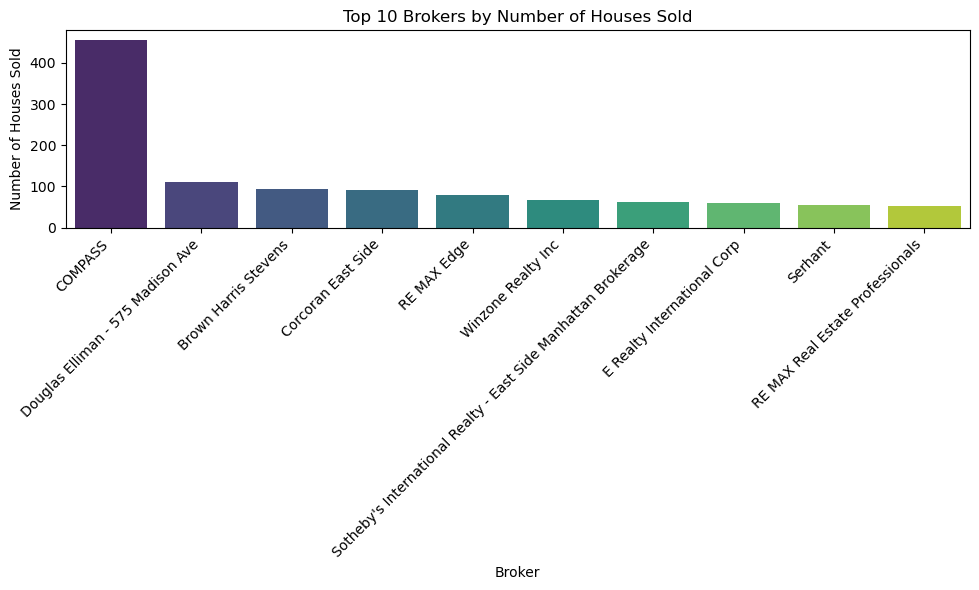

In [66]:
# Group by 'BROKERTITLE' and calculate the required statistics
broker_performance = df.groupby('BROKERTITLE').agg({
    'LOCALITY': lambda x: x.mode()[0],  # Mode of 'LOCALITY'
    'PRICE': 'mean',  # Mean of 'PRICE'
    'BROKERTITLE': 'count'  # Frequency (number of houses sold)
}).rename(columns={'BROKERTITLE': 'Frequency'}).reset_index()

# Sort brokers by the number of houses sold and select the top 10
top_brokers = broker_performance.sort_values(by='Frequency', ascending=False).head(10)

# Print the results for the top 10 brokers, removing the "Brokered by..." prefix
for index, row in top_brokers.iterrows():
    broker_title = row['BROKERTITLE'].replace("Brokered by ", "")
    print(f"Broker: {broker_title}")
    print(f"  Number of Houses Sold: {row['Frequency']}")
    print(f"  Mode LOCALITY: {row['LOCALITY']}")
    print(f"  Mean PRICE: ${row['PRICE']:.2f}")
    print()

# Plot the bar plot for the top 10 brokers
plt.figure(figsize=(10, 6))
sns.barplot(x=top_brokers['BROKERTITLE'].str.replace("Brokered by ", ""), y='Frequency', data=top_brokers, palette='viridis')
plt.xticks(rotation=45, ha='right')
plt.title('Top 10 Brokers by Number of Houses Sold')
plt.xlabel('Broker')
plt.ylabel('Number of Houses Sold')
plt.tight_layout()

# Show the plot
plt.show()

[0]	test-rmse:4435063.42862
[1]	test-rmse:4072278.17412
[2]	test-rmse:3877191.26167
[3]	test-rmse:3757552.13608
[4]	test-rmse:3630566.40519
[5]	test-rmse:3606054.81488
[6]	test-rmse:3569645.27961
[7]	test-rmse:3527969.94880
[8]	test-rmse:3543408.71748
[9]	test-rmse:3547277.56212
[10]	test-rmse:3580564.16343
[11]	test-rmse:3595798.91131
[12]	test-rmse:3592035.32607
[13]	test-rmse:3580877.29613
[14]	test-rmse:3594526.68688
[15]	test-rmse:3578229.40622
[16]	test-rmse:3585969.11614
[17]	test-rmse:3588528.58473
[18]	test-rmse:3597465.09334
[19]	test-rmse:3610176.38919
[20]	test-rmse:3610357.40354
[21]	test-rmse:3619028.82681
[22]	test-rmse:3625267.23683
[23]	test-rmse:3629159.17944
[24]	test-rmse:3627053.50591
[25]	test-rmse:3648737.95021
[26]	test-rmse:3653986.30102
[27]	test-rmse:3651376.41344


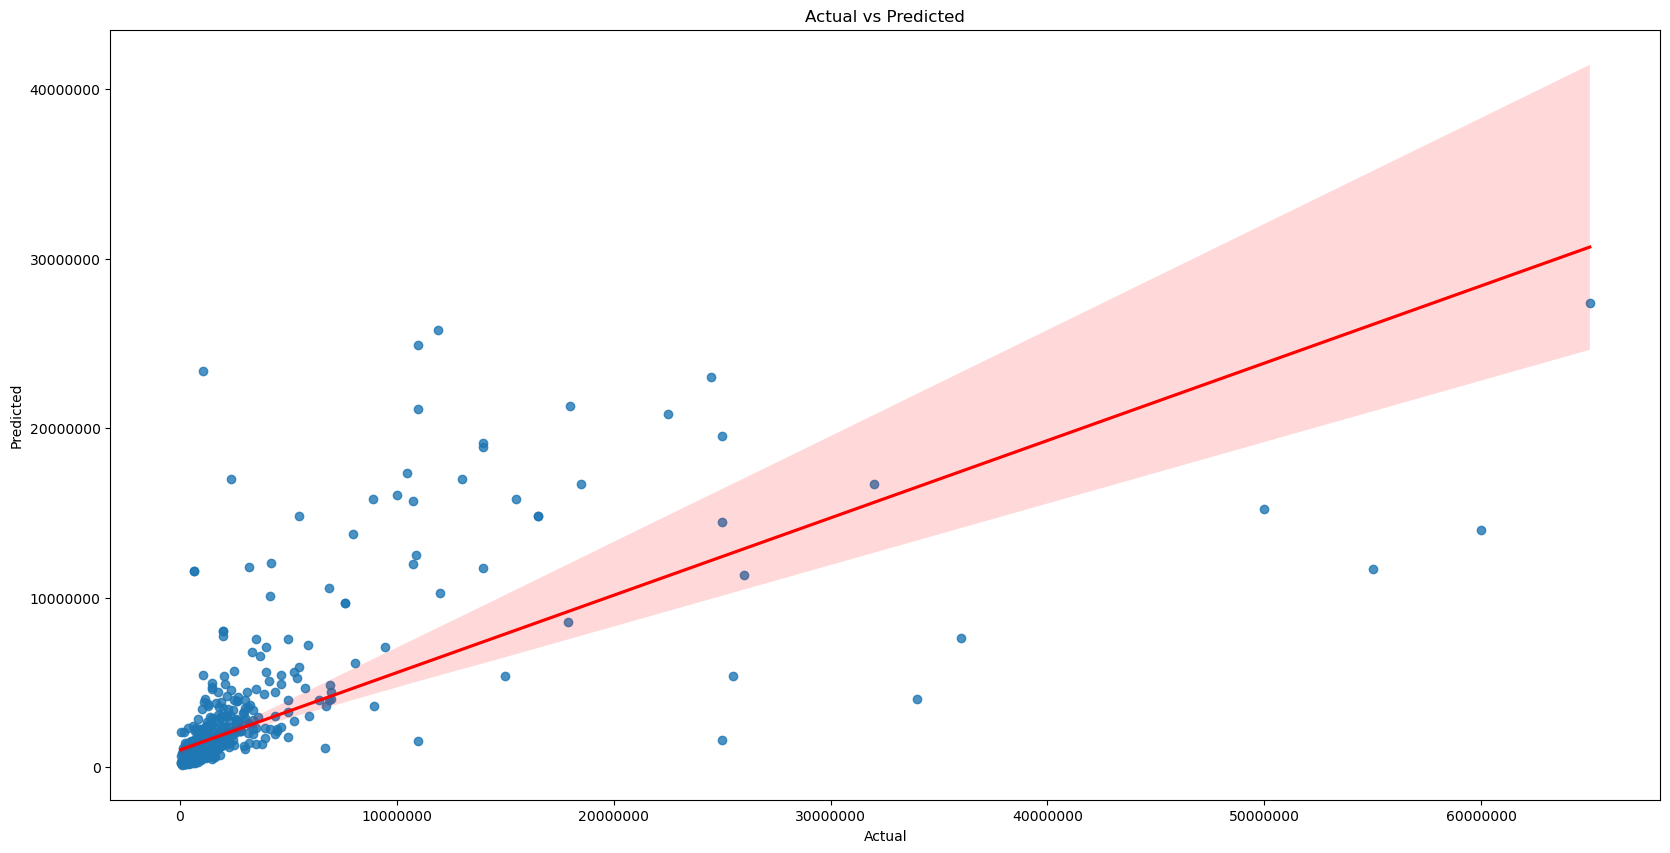

Mean Squared Error: 13332549737484.217
Accuracy: 0.9157127991675338
Precision: 0.668918918918919
F1 Score: 0.7096774193548389


In [69]:
filtered_df = df[df['PRICE'] < 1000000 ] 
# Encode categorical features without altering the original columns

label_encoder_locality = LabelEncoder()
filtered_df['LOCALITY_ENCODED'] = label_encoder_locality.fit_transform(filtered_df['LOCALITY'])

label_encoder_sublocality = LabelEncoder()
filtered_df['SUBLOCALITY_ENCODED'] = label_encoder_sublocality.fit_transform(filtered_df['SUBLOCALITY'])

label_encoder_type = LabelEncoder()
filtered_df['TYPE_ENCODED'] = label_encoder_type.fit_transform(filtered_df['TYPE'])

# Define the features and the target variable using the encoded columns
X = df[['BEDS', 'BATH', 'LOCALITY_ENCODED', 'SUBLOCALITY_ENCODED', 'PROPERTYSQFT', 'TYPE_ENCODED']]
y = df['PRICE']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the feature variables
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert the dataset into DMatrix, which is a data structure used by XGBoost for training
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Set up the parameters for XGBoost
params = {
    'objective': 'reg:squarederror',
    'seed': 42,
    'eval_metric': 'rmse'
}

# Train the model with early stopping
clf_xgb_v1 = xgb.train(params, 
                       dtrain, 
                       num_boost_round=1000, 
                       evals=[(dtest, 'test')], 
                       early_stopping_rounds=20, 
                       verbose_eval=True)

# Make predictions on the test set
y_preds = clf_xgb_v1.predict(dtest)

# Plot Actual vs Predicted values
fig = plt.figure(figsize=(20, 10))
sns.regplot(x=y_test, y=y_preds, x_jitter=.15, line_kws=dict(color="r"))
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')
plt.ticklabel_format(style='plain')
plt.show()

# Calculate and print the Mean Squared Error
mse = mean_squared_error(y_test, y_preds)
print(f"Mean Squared Error: {mse}")

# Since XGBRegressor is a regression model, converting continuous predictions to binary classes
threshold = np.mean(y)  # Using mean as a threshold
y_pred_class = (y_preds > threshold).astype(int)
y_test_class = (y_test > threshold).astype(int)

# Calculate accuracy, precision, and F1 score
accuracy = accuracy_score(y_test_class, y_pred_class)
precision = precision_score(y_test_class, y_pred_class)
f1 = f1_score(y_test_class, y_pred_class)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"F1 Score: {f1}")